In [78]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [79]:
from autoplan.trainer import ParserTrainer, ClassEvaluation, ClassifierTrainer
from autoplan.token import OCamlTokenizer
from autoplan.vis import plot_accuracy, plot_cm, plot_loss
from autoplan.dataset import TrainVal, RandomSplit, build_synthetic_dataset, set_random_seed
from autoplan.generator import ProgramGenerator
from grammars.rainfall.ocaml2 import Program, Labels, CountWhere
from autoplan.parsing import ProgramParser
from autoplan.neighbors import TreeNNClassifier
from autoplan.models import NeuralParser 

import pandas as pd
from tqdm.auto import tqdm
from scripts.rainfall_ingest import load_full_t1, ingest_dataset, load_new_labels
import torch
import seaborn as sns
from iterextras import par_for
from pickle_cache import PickleCache
from torch import nn
import numpy as np
import dataclasses
import os

pcache = PickleCache()
device = torch.device('cuda:7')

In [80]:
dataset = load_full_t1()

Skipped 16 programs


In [96]:
synth_dataset = pcache.get('synth_ocaml_data')

In [97]:
model_opts = {
    'model': nn.LSTM, 
    'embedding_size': 128, 
    'hidden_size': 512
}

model_path = os.path.expanduser('~/autoplan/data/rainfall/models/cfg10_epoch120.pt')
parser = ProgramParser(Program(), synth_dataset, model_path, device=device, model_opts=model_opts)

In [98]:
ds = dataset
parses = []
for batch in ds.loader(ds.dataset):
    for i in range(len(batch['program'])):
        _, parse = parser.infer(
            batch['program'][i].unsqueeze(0), batch['program_len'][i].unsqueeze(0))
        parses.append(parse)

In [99]:
Y = [int(item['countwhere']) for item in dataset.dataset]

In [84]:
for item in dataset.dataset:
    print(item['source'])
    print(item['countwhere'])
    print('='*30 + '\n\n')

let rec rainfall (alof : float list) =
  (let rec sum_helper (alof : float list) (sum : float) (counter : float) =
     (match (alof, counter) with
      | ([], 0.) -> failwith "Empty list."
      | ((-999.)::_, 0.) -> failwith "Empty list."
      | ([], _) -> (sum, counter)
      | ((-999.)::_, _) -> (sum, counter)
      | (hd::tl, _) ->
          if hd >= 0.
          then sum_helper tl (sum +. hd) (counter +. 1.)
          else sum_helper tl sum counter : (float * float)) in
   match sum_helper alof 0. 0. with | (s, c) -> s /. c : float)

CountWhere.Helper


let rec rainfall_helper (alon : int list) (sum : int) (num_elements : int) =
  (match alon with
   | [] -> if num_elements = 0 then 0 else sum / num_elements
   | hd::tail ->
       if hd = (-999)
       then (if num_elements = 0 then 0 else sum / num_elements)
       else
         if hd > (-1)
         then rainfall_helper tail (sum + hd) (num_elements + 1)
         else rainfall_helper tail sum num_elements : int)
let rainfall

In [100]:
def heuristic_clf(X):
    strat = Labels(X['strategy'][1])
    if strat == Labels.CleanFirst:
        return CountWhere.Rainfall if X['helper_in_body'][1] or X['average_strategy'][1] != 'direct' \
                else CountWhere.Helper
    elif strat == Labels.CleanInSC:
        return CountWhere.Rainfall if X['anonymous_helpers'][1] else CountWhere.Own
    elif strat == Labels.SingleLoop:
        return CountWhere.Helper

In [104]:
def heuristic_clf2(X):
    strat = Labels(X['strategy'][1])
    
    if strat == Labels.CleanFirst:
        return CountWhere.Rainfall if X['average_strategy'][1] != 'direct' \
                else CountWhere.Helper
    
    elif strat == Labels.CleanInSC:
        return CountWhere.Rainfall if X['anonymous_helpers'][1] else CountWhere.Own
    
    elif strat == Labels.SingleLoop:
        return CountWhere.Helper if X['rainfall_body_specs'][1] == 'direct_pass' or 'match' \
                else CountWhere.Rainfall

0.8308823529411765


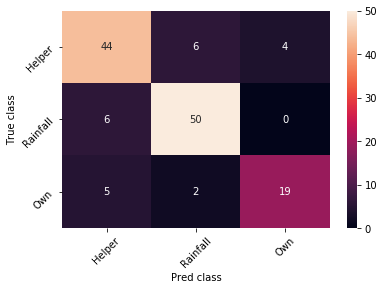

In [108]:
Ypred = [int(heuristic_clf2(X)) for X in parses]
evl = ClassEvaluation.from_preds(Y, Ypred, ['Helper', 'Rainfall', 'Own'])
print(evl.accuracy)
evl.plot_cm(normalize=False)

In [70]:
parses[55]

OrderedDict([('START', (0, None)),
             ('recursion', (1, 'rec')),
             ('_type', (0, 'int')),
             ('uses_annotation', (0, True)),
             ('helper_in_body', (1, False)),
             ('raises_failwith', (0, True)),
             ('fail_message', (0, '"No rain was collected"')),
             ('strategy', (0, <GeneralRainfallLabels.SingleLoop: 2>)),
             ('rainfall_body_specs', (0, 'direct_pass')),
             ('recursion_strategy', (1, 'let')),
             ('check_empty_list', (1, '[] | -999')),
             ('check_div_by_zero', (0, True)),
             ('gt_zero', (0, True)),
             ('separate_sentinel_check', (0, True)),
             ('recurse_empty_list', (1, False)),
             ('check_positive_head', (1, False))])

In [69]:
evl.print_incorrect(dataset, list(CountWhere))

Program 6:
let rainfall (alon : float list) =
  (let rec rainfall_helper alon =
     match alon with
     | [] -> (0., 0)
     | (-999.)::tl -> (0., 0)
     | hd::tl when hd < 0. -> rainfall_helper tl
     | hd::tl -> let (x, inc) = rainfall_helper tl in ((hd +. x), (succ inc)) in
   let (x, inc) = rainfall_helper alon in
   if inc = 0
   then failwith "failed to find valid measurements"
   else x /. (float inc) : float)

Pred: CountWhere.Rainfall
True: CountWhere.Helper

Program 14:
let rec rainfall_help (alon : float list) (k : float) =
  (match alon with
   | [] -> (0., k)
   | hd::tl ->
       (match hd with
        | (-999.) -> (0., k)
        | n when n >= 0. ->
            (match rainfall_help tl (k +. 1.) with | (s, n) -> ((hd +. s), n))
        | n when n < 0. -> (match rainfall_help tl k with | (s, n) -> (s, n))) : 
  (float * float))
let rainfall (alon : float list) =
  (match rainfall_help alon 0. with
   | (0., 0.) -> 0.
   | (sum, num) -> sum /. num : float)

Pred: CountW